# Implementation of K-SVD and comparing with numerical methods

## Numerical tour of image processing for denoising

#### Teacher: Vincent JAQUEN
##### Students: Sofia PISTONE, Gonzalo BECKER, Andrea URQUIZA, Rogerio BOMBARDELLI, Joaquin OPAZO
##### 20 Janvier

### Install required packages

In [1]:
pip install medpy k_svd

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement k_svd (from versions: none)
ERROR: No matching distribution found for k_svd


### Usefull functions

In [2]:
def rescale01(I):
  I = np.interp(I,(I.min(),I.max()),(0,1))
  return I

### Imports

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import skimage
import gputools
import k_svd

from tabulate import tabulate
from medpy.filter.smoothing import anisotropic_diffusion as AD
from skimage import data, img_as_float
from skimage.filters import gaussian as gs
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error as mse

If you want to compute separable approximations, please install it with
pip install scikit-tensor-py3


### Import ground truth and noise image

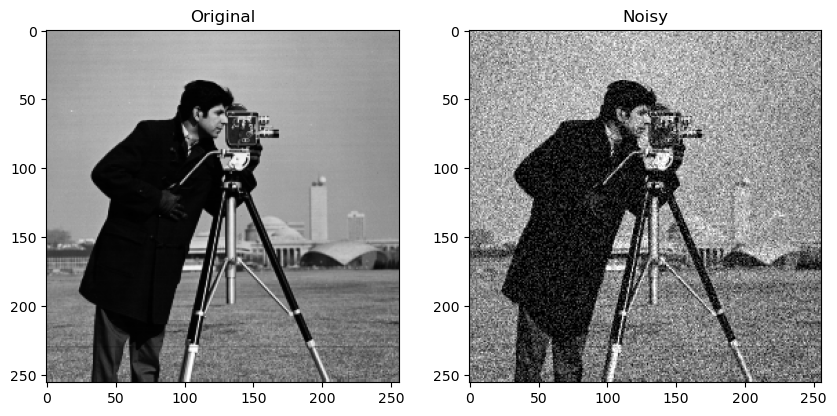

In [4]:
img = plt.imread('./cameraman.bmp')
img = rescale01(img)
noisy = plt.imread('./cameraman_noisy.bmp')
noisy = rescale01(noisy)

plt.figure(figsize=(10,10))
plt.subplot(1,2,1).set_title("Original")
plt.imshow(img, cmap='gray')
plt.subplot(1,2,2).set_title("Noisy")
plt.imshow(noisy, cmap='gray')
plt.show()

### Applying different filters to compare

In [5]:
noisyAD = AD(noisy, 17, kappa = 0.20368)
noisyAD = rescale01(noisyAD)

c:\Users\jaopa\anaconda3\lib\site-packages\medpy\filter\smoothing.py:155: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  deltas[i][slicer] = numpy.diff(out, axis=i)
c:\Users\jaopa\anaconda3\lib\site-packages\medpy\filter\smoothing.py:164: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  matrices[i][slicer] = numpy.diff(matrices[i], axis=i)


In [6]:
Gaussian = gs(noisy, sigma = 0.79157)
Gaussian = rescale01(Gaussian)

In [7]:
Bilateral = gputools.denoise.bilateral2(noisy,2,0.27684)
Bilateral = rescale01(Bilateral)

In [8]:
NLM = gputools.denoise.nlm2(noisy,0.14578,2,3)
NLM = rescale01(NLM)

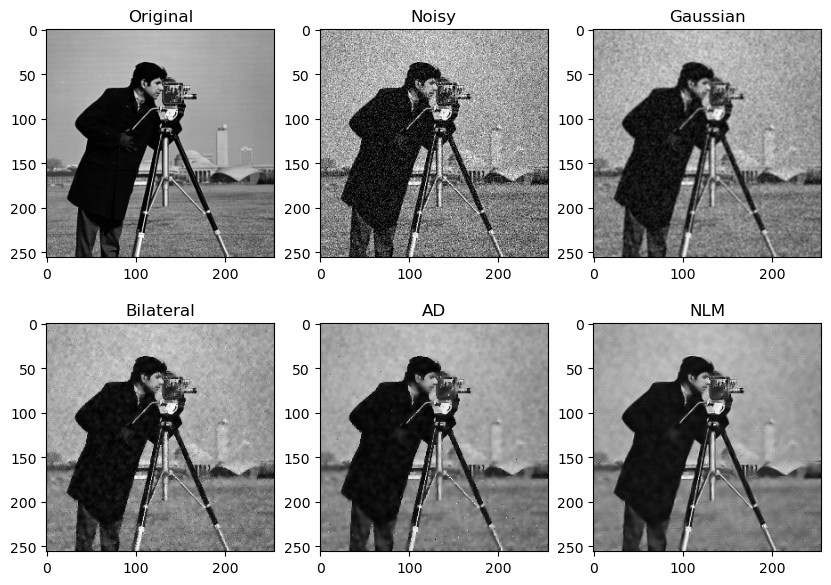

In [9]:
plt.figure(figsize=(10,7))
plt.subplot(2,3,1).set_title("Original")
plt.imshow(img, cmap='gray')
plt.subplot(2,3,2).set_title("Noisy")
plt.imshow(noisy, cmap='gray')
plt.subplot(2,3,3).set_title("Gaussian")
plt.imshow(Gaussian, cmap='gray')
plt.subplot(2,3,4).set_title("Bilateral")
plt.imshow(Bilateral, cmap='gray')
plt.subplot(2,3,5).set_title("AD")
plt.imshow(noisyAD, cmap='gray')
plt.subplot(2,3,6).set_title("NLM")
plt.imshow(NLM, cmap='gray')
plt.show()

### Numerical comparation

In [10]:
names = {"GT":img,"Noisy":noisy,"AD":noisyAD,"Gaussian":Gaussian,"Bilateral":Bilateral,"NLM":NLM}

In [11]:
table=[["Ground Truth","Sigma Value","PSNR","SSIM","MSE"]]

for i in names:    
    temp1 = psnr(img,names[i])
    temp2 = ssim(img,names[i], data_range = names[i].max() - names[i].min())
    temp3 = mse(img,names[i])  
    
    array = []
    array.append("GT")
    array.append(i)
    array.append(temp1)
    array.append(temp2)
    array.append(temp3)

    table.append(array)
print(tabulate(table, headers="keys",tablefmt="fancy_grid"))

╒══════════════╤═════════════╤════════════════════╤═════════════════════╤═══════════════════════╕
│ 0            │ 1           │ 2                  │ 3                   │ 4                     │
╞══════════════╪═════════════╪════════════════════╪═════════════════════╪═══════════════════════╡
│ Ground Truth │ Sigma Value │ PSNR               │ SSIM                │ MSE                   │
├──────────────┼─────────────┼────────────────────┼─────────────────────┼───────────────────────┤
│ GT           │ GT          │ inf                │ 1.0                 │ 0.0                   │
├──────────────┼─────────────┼────────────────────┼─────────────────────┼───────────────────────┤
│ GT           │ Noisy       │ 18.88799274365978  │ 0.30991907938180274 │ 0.012918161974117836  │
├──────────────┼─────────────┼────────────────────┼─────────────────────┼───────────────────────┤
│ GT           │ AD          │ 25.775532799039734 │ 0.6949138408046885  │ 0.002645128166493043  │
├──────────────┼────

c:\Users\jaopa\anaconda3\lib\site-packages\skimage\metrics\simple_metrics.py:163: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


### K-SVD Implementation 

In [12]:
def im2col(image,blockSize,step): 

    M,N=image.shape
    rowNumber=int((M-blockSize)/step)+1
    colNumber=int((N-blockSize)/step)+1
    rows=[i*step for i in range(rowNumber)]
    cols=[i*step for i in range(colNumber)]
    if (rowNumber-1)*step+blockSize<M:
        rows.append(M-blockSize)
    if (colNumber-1)*step+blockSize<N:
        cols.append(N-blockSize)
    repmat=np.array([[image[i:i+blockSize,j:j+blockSize] for j in cols] for i in rows])
    repmat=np.reshape(repmat,[len(rows),len(cols),blockSize*blockSize])
    repmat=np.reshape(repmat,[len(rows)*len(cols),blockSize*blockSize])

    return repmat,rows,cols

In [24]:
import cv2
sigma = 1
blockSize = 8

step = 1

maxBlockToTrain = 65000
maxBlockToConsider = 260000

image = cv2.imread('cameraman.bmp',0)
# image = rescale01(image)
noisy2 = cv2.imread('cameraman_noisy.bmp',0)
# noisy2 = rescale01(noisy2)

dataMatrix,_,_ = im2col(noisy2,blockSize,step)
np.random.shuffle(dataMatrix)
dataMatrix=np.transpose(dataMatrix,[1,0])

if dataMatrix.shape[1]>maxBlockToTrain:
    dataMatrix=dataMatrix[:,:maxBlockToTrain]  # shape [n,N]

#subtract the DC value from the original signal
mean = np.sum(dataMatrix,0)/dataMatrix.shape[0]
dataMatrix = dataMatrix-np.tile(mean,[dataMatrix.shape[0],1])

#construct the k-svd object to do the sparse coding
ksvd = k_svd.ksvd(words = 512, iteration = 10, errGoal = sigma*1.15)
dictionary = ksvd.constructDictionary(dataMatrix)
print("finish dictionary training")

# denoising the image using the resulted dictionary
while ((img.shape[0]-blockSize)/step+1)*((img.shape[1]-blockSize)/step+1)>maxBlockToConsider:
    step+=1

dataMatrix,rowIndex,colIndex = im2col(noisy2,blockSize,step)
dataMatrix = np.transpose(dataMatrix,[1,0])
n,N = dataMatrix.shape
processstep = 100000
maxStep = N//processstep

if N%processstep:
    maxStep+=1

for i in range(maxStep):
    maxColumn = np.minimum((i+1)*processstep,N)
    mean = np.sum(dataMatrix[:,i*processstep:maxColumn],0)/n
    dataMatrix[:,i*processstep:maxColumn] -= np.tile(mean,[n,1]).astype(np.uint8)
    coef = ksvd.OMP(dictionary,dataMatrix[:,i*processstep:maxColumn],sigma*1.15,showFlag=False)
    dataMatrix[:,i*processstep:maxColumn] = np.dot(dictionary,coef)+np.tile(mean,[n,1])


imageOut = np.zeros(img.shape)
weight = np.zeros(img.shape)

for i,r in enumerate(rowIndex):
    for j,c in enumerate(colIndex):
        block = np.reshape(dataMatrix[:,i*len(rowIndex)+j],[blockSize,blockSize])
        imageOut[r:r+blockSize,c:c+blockSize] += block
        weight[r:r+blockSize,c:c+blockSize] += 1

denoised = (imageOut/weight).astype(np.uint8)

psnrr = psnr(rescale01(img),rescale01(denoised))
print(psnrr)

plt.figure(figsize=(14,14))
plt.subplot(1,3,1).set_title("Original")
plt.imshow(img, cmap='gray')
plt.subplot(1,3,2).set_title("Noisy")
plt.imshow(noisy2, cmap='gray')
plt.subplot(1,3,3).set_title("Denoised")
plt.imshow(denoised, cmap='gray')
plt.show()


dictionary initializaiton done
done with the 19% data coding
done with the 39% data coding
done with the 59% data coding
done with the 79% data coding
done with the 99% data coding


KeyboardInterrupt: 

## TESTING AREA

In [14]:
sigmas = np.arange(0,40)
table=[["Ground Truth","Sigma Value","PSNR","SSIM","MSE"]]

for i in sigmas:
    test = AD(noisy, i, kappa = 0.20368)
    test = rescale01(test)
    
    temp1 = psnr(img,test)
    temp2 = ssim(img,test, data_range = test.max() - test.min())
    temp3 = mse(img,test)  
    
    array = []
    array.append("GT")
    array.append(i)
    array.append(temp1)
    array.append(temp2)
    array.append(temp3)

    table.append(array)
print(tabulate(table, headers="keys",tablefmt="fancy_grid"))

╒══════════════╤═════════════╤════════════════════╤═════════════════════╤═══════════════════════╕
│ 0            │ 1           │ 2                  │ 3                   │ 4                     │
╞══════════════╪═════════════╪════════════════════╪═════════════════════╪═══════════════════════╡
│ Ground Truth │ Sigma Value │ PSNR               │ SSIM                │ MSE                   │
├──────────────┼─────────────┼────────────────────┼─────────────────────┼───────────────────────┤
│ GT           │ 0           │ 18.88799261509842  │ 0.30991907710949074 │ 0.01291816235652576   │
├──────────────┼─────────────┼────────────────────┼─────────────────────┼───────────────────────┤
│ GT           │ 1           │ 19.76726563535401  │ 0.3339927544341591  │ 0.01055050958720362   │
├──────────────┼─────────────┼────────────────────┼─────────────────────┼───────────────────────┤
│ GT           │ 2           │ 20.652250448390234 │ 0.3612190899117773  │ 0.008605477138056199  │
├──────────────┼────